In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np
#Disable Warnings
import warnings
warnings.filterwarnings("ignore")

import optuna
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Evaluation
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold, cross_val_score, KFold # to split the data
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score #To evaluate our model

# Algorithmns models to be compared
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import  RobustScaler,  LabelEncoder

import tensorflow as tf
#from keras.wrappers.scikit_learn import KerasClassifier
#from keras.utils import np_utils

# 1. EDA and Visualization

## Load data and check data shape

In [2]:
datadir = os.path.join(os.getcwd(),'dataset')
list_files = os.listdir(datadir)
df = []
for f in list_files:
    filepath = os.path.join(datadir,f)
    df.append(pd.read_csv(filepath, sep= ';'))
df = pd.concat(df)
df = df.reset_index(drop=True)
df.shape

(125, 15)

We have 125 rows of data

## Checking null values

In [3]:
df.isna().sum()

0.799_0.201_MIP    0
0.799_0.201_NP     0
0.700_0.300_MIP    0
0.700_0.300_NP     0
0.600_0.400_MIP    0
0.600_0.400_NP     0
0.501_0.499_MIP    0
0.501_0.499_NP     0
0.400_0.600_MIP    0
0.400_0.600_NP     0
1-Octanol          0
1-Propanol         0
2-Butanol          0
2-propanol         0
1-isobutanol       0
dtype: int64

In [4]:
df.columns

Index(['0.799_0.201_MIP', '0.799_0.201_NP', '0.700_0.300_MIP',
       '0.700_0.300_NP', '0.600_0.400_MIP', '0.600_0.400_NP',
       '0.501_0.499_MIP', '0.501_0.499_NP', '0.400_0.600_MIP',
       '0.400_0.600_NP', '1-Octanol', '1-Propanol', '2-Butanol', '2-propanol',
       '1-isobutanol'],
      dtype='object')

## Checking target distribution

In [5]:
df[['1-Octanol', '1-Propanol', '2-Butanol', '2-propanol',
       '1-isobutanol']].sum()

1-Octanol       25
1-Propanol      25
2-Butanol       25
2-propanol      25
1-isobutanol    25
dtype: int64

## Combine target columns into one column

In [6]:
df['Target'] = np.where(df['1-Octanol'] == 1, '1-Octanol',
                       np.where(df['1-Propanol'] == 1, '1-Propanol',
                                np.where(df['2-Butanol'] == 1, '2-Butanol',
                                         np.where(df['2-propanol'] == 1, '2-propanol','1-isobutanol'))))
df['Target'].value_counts()

Target
1-Octanol       25
1-Propanol      25
2-Butanol       25
2-propanol      25
1-isobutanol    25
Name: count, dtype: int64

In [7]:
df = df.drop(columns=['1-Octanol', '1-Propanol', '2-Butanol', '2-propanol',
       '1-isobutanol'])
df.head()

,0.799_0.201_MIP,0.799_0.201_NP,0.700_0.300_MIP,0.700_0.300_NP,0.600_0.400_MIP,0.600_0.400_NP,0.501_0.499_MIP,0.501_0.499_NP,0.400_0.600_MIP,0.400_0.600_NP,Target
0,-11.98,-10.99,-19.12,-17.28,-33.13,-28.45,-48.83,-40.77,-62.49,-50.82,1-Octanol
1,-12.15,-11.33,-22.33,-19.95,-39.82,-33.64,-56.90,-46.77,-73.32,-58.96,1-Octanol
2,-12.58,-11.74,-26.67,-23.34,-46.48,-38.69,-65.95,-53.46,-84.53,-67.21,1-Octanol
3,-13.79,-12.82,-30.56,-26.18,-52.30,-42.98,-73.81,-59.19,-94.41,-74.40,1-Octanol
4,-15.73,-13.87,-34.54,-28.65,-57.44,-46.26,-80.37,-63.49,-102.94,-80.25,1-Octanol


## Investigate data distribution

In [8]:
df.groupby(['Target']).aggregate({'mean','median'})

0.799_0.201_MIP        0.799_0.201_NP        0.700_0.300_MIP  \
                        mean median           mean median            mean   
Target                                                                      
1-Octanol           -14.1772 -13.18       -15.1064 -14.28        -27.5168   
1-Propanol          -65.0140 -60.41       -63.1420 -60.88        -98.5596   
1-isobutanol        -56.3880 -57.71       -55.5756 -57.35        -92.0540   
2-Butanol           -71.5960 -80.61       -71.9616 -69.71       -112.2804   
2-propanol          -54.7472 -66.12       -51.8604 -56.38        -82.8900   

                     0.700_0.300_NP         0.600_0.400_MIP          \
              median           mean  median            mean  median   
Target                                                                
1-Octanol     -26.42       -29.4304  -28.29        -44.6900  -41.29   
1-Propanol   -100.87       -89.3404  -90.63       -135.6216 -153.09   
1-isobutanol  -92.83       -88.2468  -93.91       -135.8868 -134.83   
2-Butanol    -119.26      -107.4956 -110.41       -161.5220 -175.38   
2-propanol    -94.75       -76.2628  -86.03       -107.6752 -118.70   

             0.600_0.400_NP         0.501_0.499_MIP         0.501_0.499_NP  \
                       mean  median            mean  median           mean   
Target                                                                       
1-Octanol          -46.6988  -43.00        -62.7356  -59.78       -64.7688   
1-Propanol        -119.4320 -127.88       -173.8944 -200.89      -151.0608   
1-isobutanol      -128.7528 -137.56       -188.6940 -182.33      -176.2628   
2-Butanol         -147.9260 -158.87       -204.0676 -220.91      -184.8968   
2-propanol         -96.3856 -109.68       -127.7952 -142.31      -113.6116   

                     0.400_0.600_MIP         0.400_0.600_NP          
              median            mean  median           mean  median  
Target                                                               
1-Octanol     -57.89        -82.1196  -81.51       -83.9128  -73.99  
1-Propanol   -165.88       -219.4472 -232.82      -189.5036 -194.70  
1-isobutanol -187.16       -249.5308 -243.12      -232.0444 -250.30  
2-Butanol    -211.24       -251.7840 -264.81      -225.5976 -259.99  
2-propanol   -129.79       -150.5868 -172.51      -134.9360 -155.89

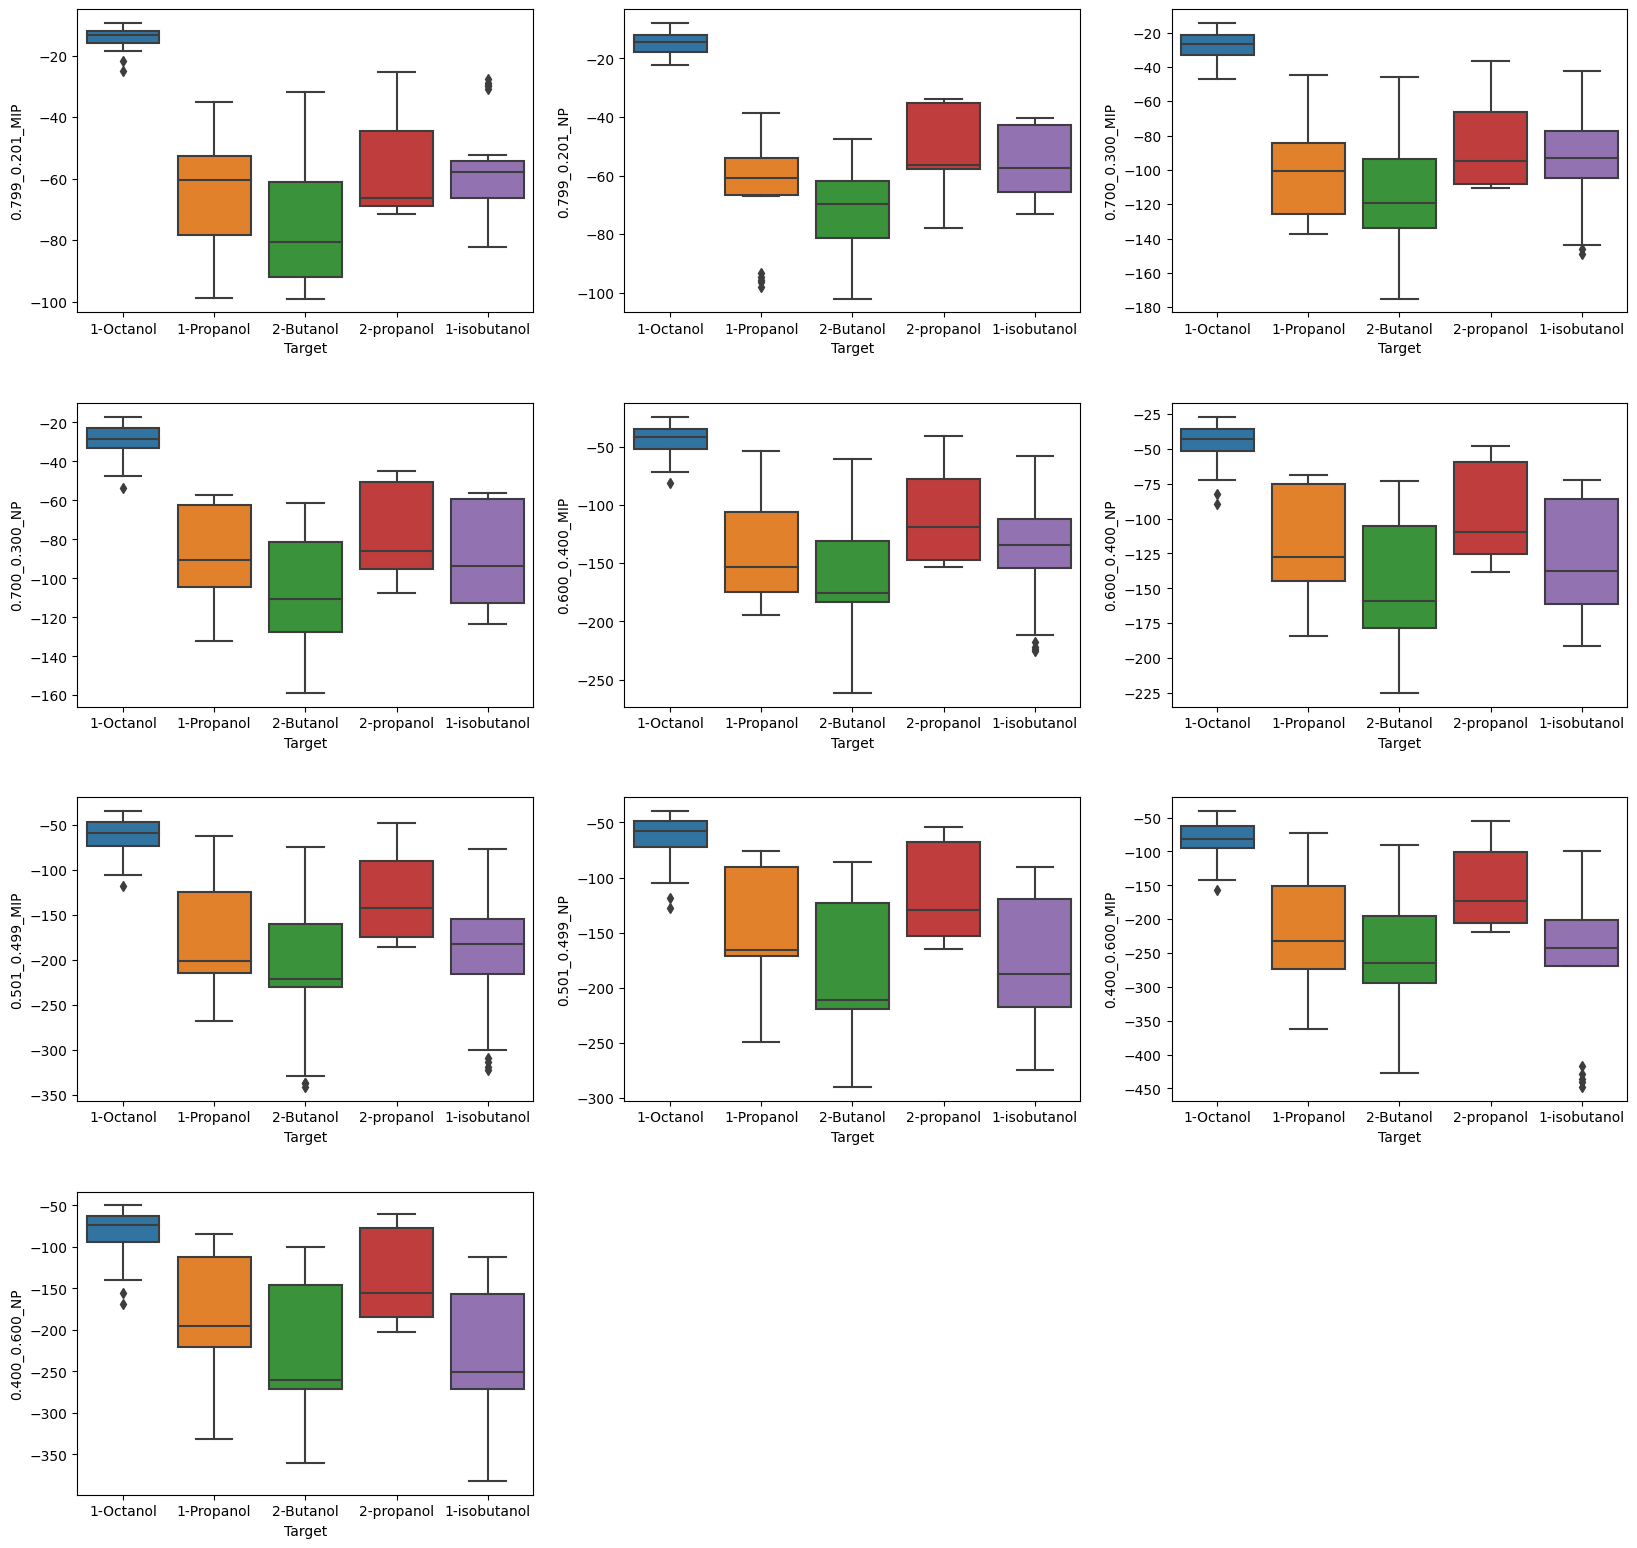

In [9]:
feature_columns = df.drop('Target',axis=1).select_dtypes(include='number').columns.tolist()
# Create Box Plot based on Target
f=plt.figure(figsize=(20,50))
for i,col in enumerate(feature_columns):
    f.add_subplot(10,3,i+1)
    sns.boxplot(y=df[col], x=df['Target'])
    plt.subplots_adjust(hspace=0.3)
plt.show()

- 1-Octanol generally has higher value across all features
- 2-Propanol generally has the second highest value across all features
- 2-Butanol generally has lower value across all features
- 1-isobutanol and 2-Butanol has widest range among other


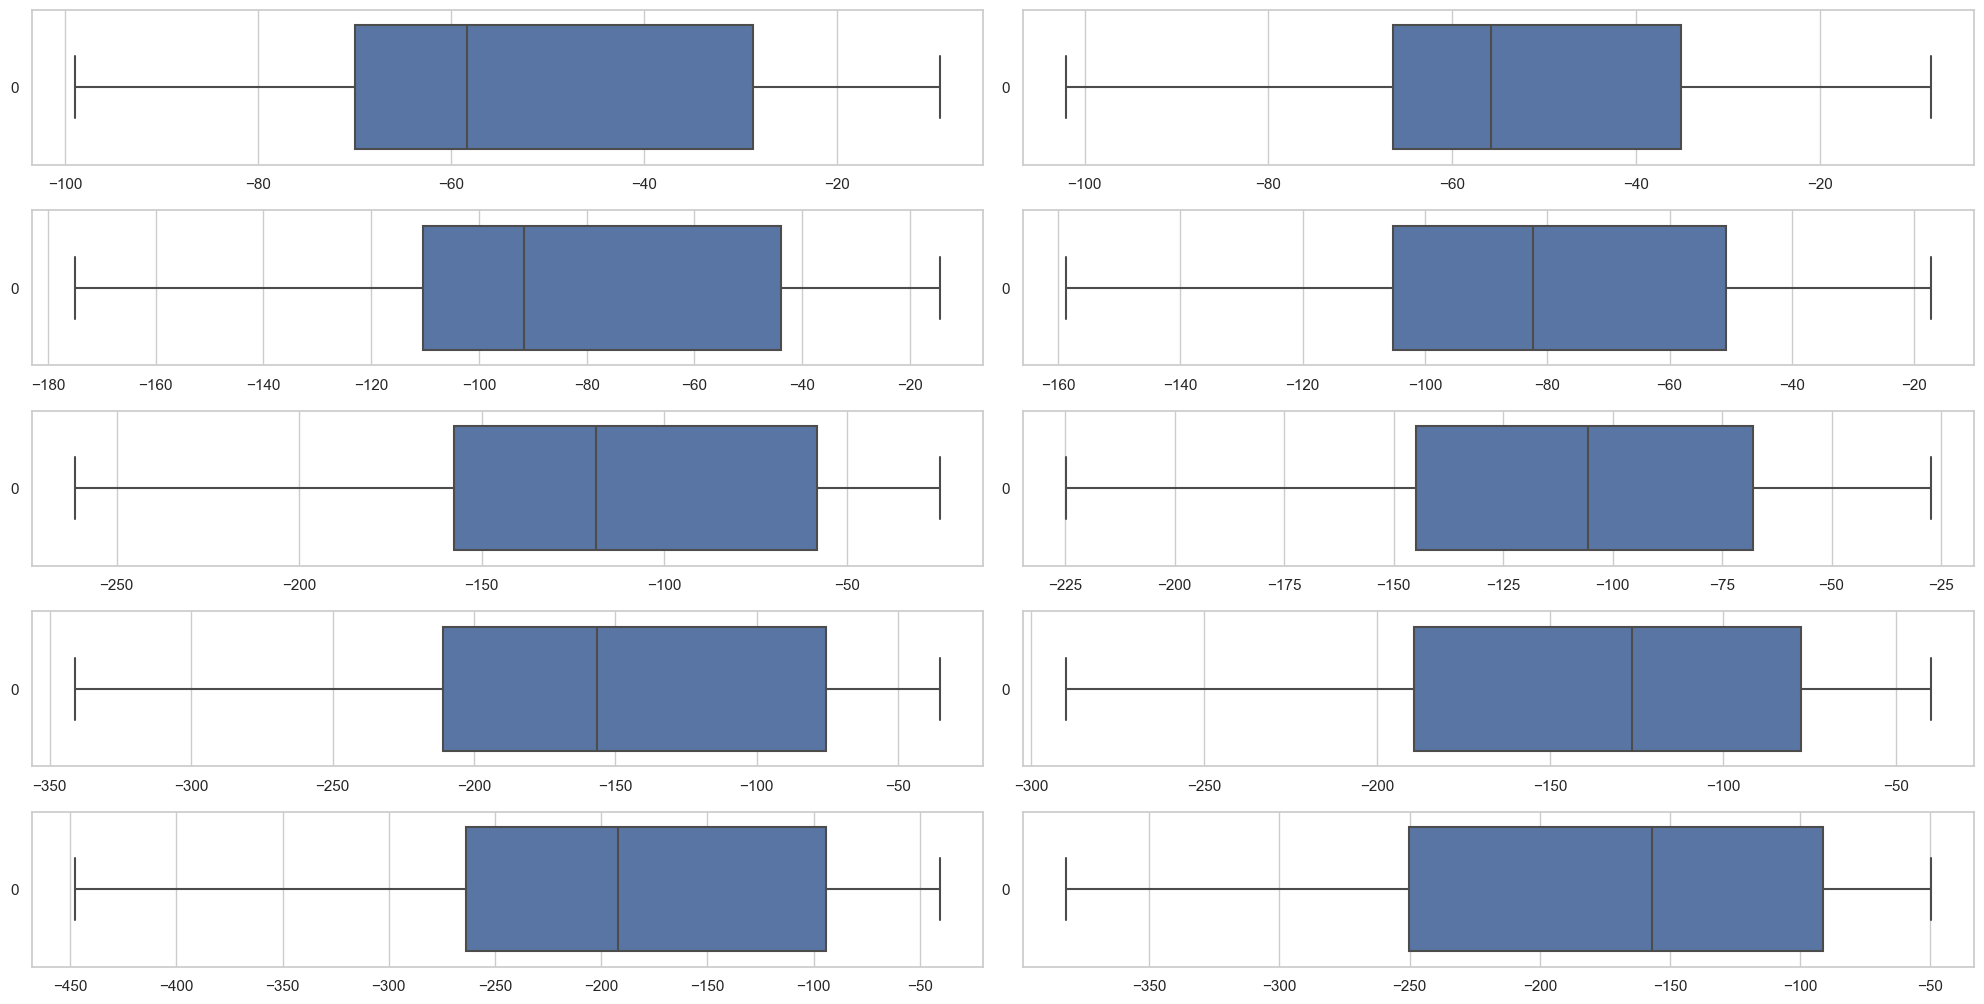

In [10]:
sns.set_theme(style="whitegrid")
f=plt.figure(figsize=(20,40))
for i,col in enumerate(feature_columns):
    f.add_subplot(20,2,i+1)
    sns.boxplot(df[col], orient = 'h')
    plt.subplots_adjust(hspace=0.7)
    
plt.tight_layout()
plt.show()

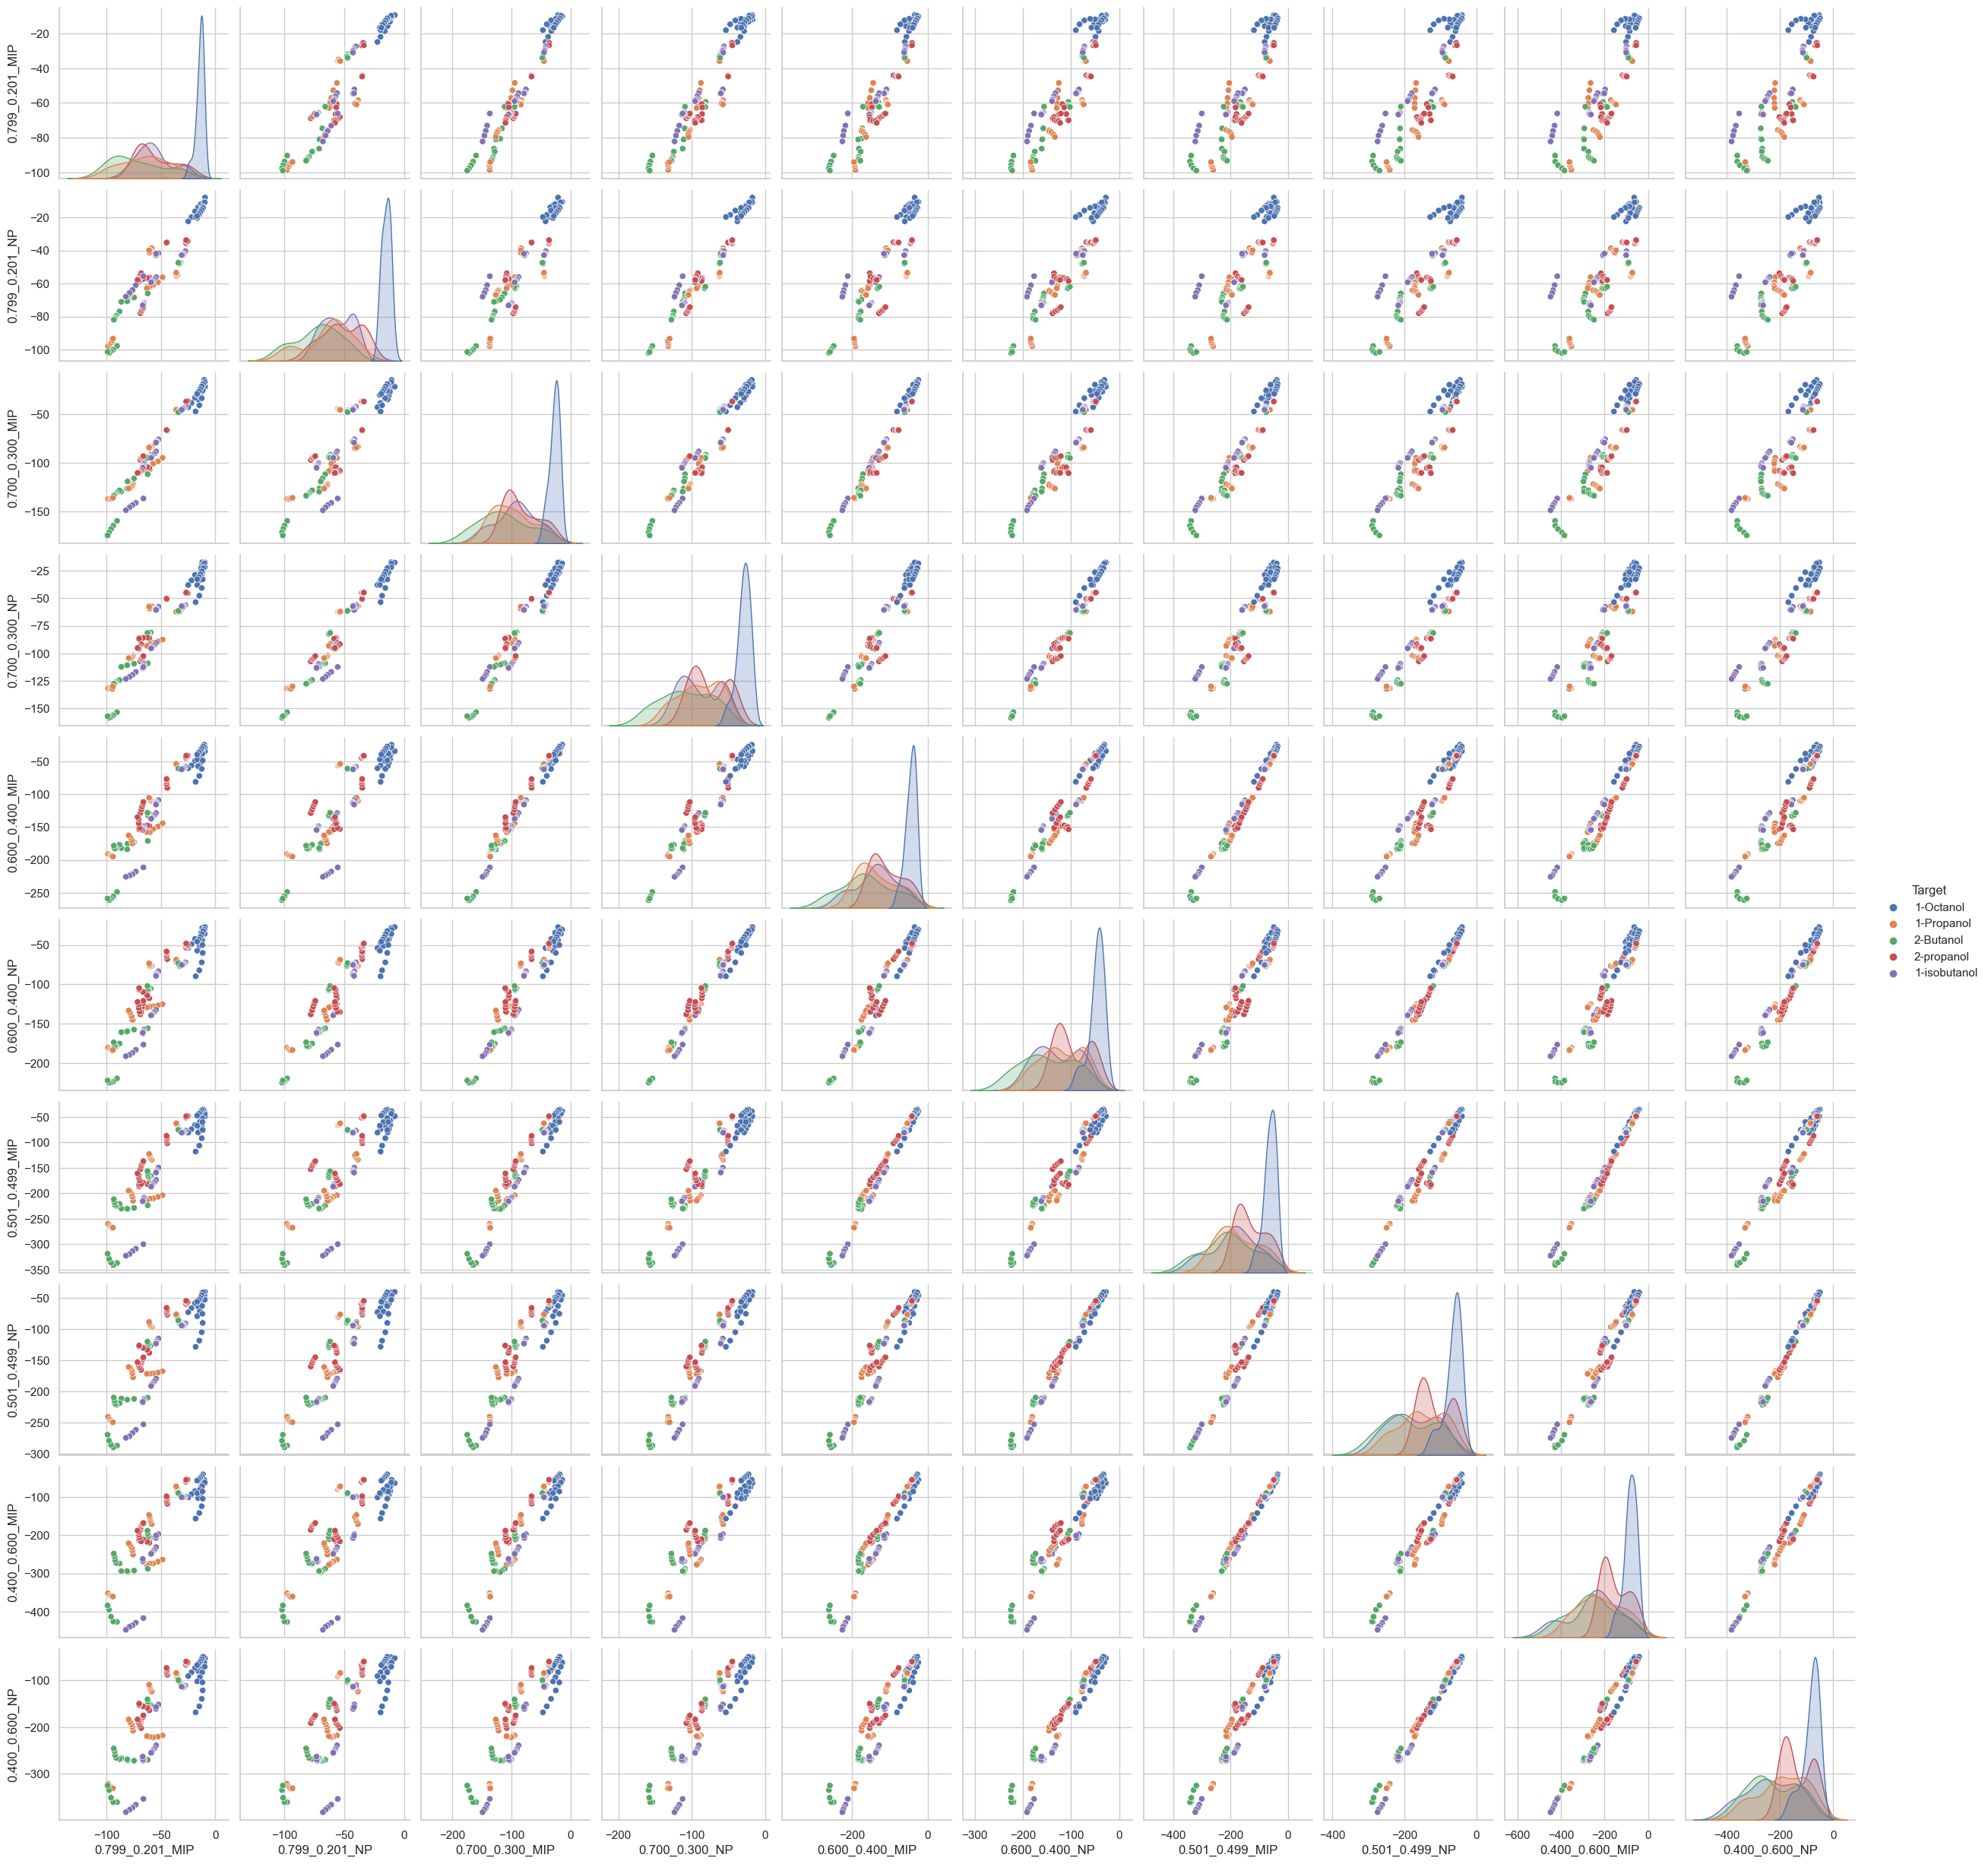

In [11]:
sns.pairplot(df,hue='Target')

## Investigate feature correlation

<Axes: >

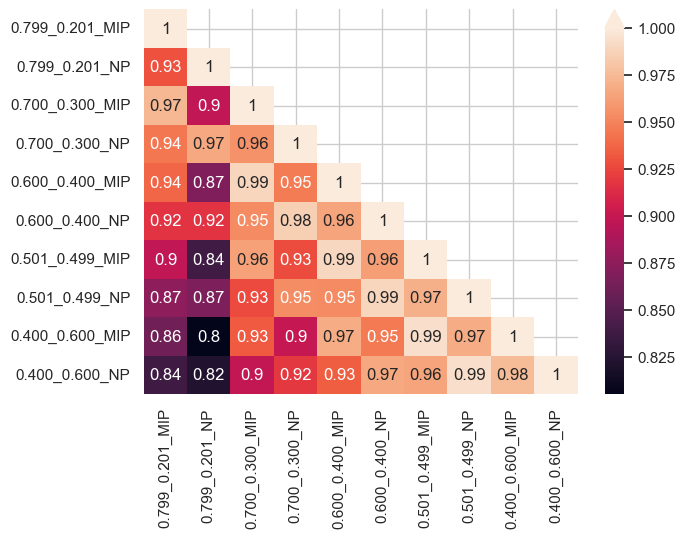

In [12]:
corr_matrix = df.drop(columns=['Target']).corr().abs()

# Select upper triangle of correlation matrix
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k = 0).astype('bool'))

# Heat map of numeric variable correlation 
green = sns.light_palette("seagreen", reverse = True, as_cmap = True)
green.set_over('tomato')
plt.figure(figsize = (7,5))
sns.heatmap(lower
            , annot = True
            , cbar_kws = {'extend': 'max'}
            )

In [13]:
vif = pd.DataFrame()
vif["Feature"] = df[feature_columns].columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(df[feature_columns].values, i)
              for i in range(len(df[feature_columns].columns))]

vif

,Feature,VIF
0,0.799_0.201_MIP,780.677851
1,0.799_0.201_NP,1244.181505
2,0.700_0.300_MIP,5003.920222
3,0.700_0.300_NP,7272.932500
4,0.600_0.400_MIP,7338.317107
5,0.600_0.400_NP,10161.624513
6,0.501_0.499_MIP,16477.548419
7,0.501_0.499_NP,24672.303468
8,0.400_0.600_MIP,10565.116289
9,0.400_0.600_NP,12765.049132


Because the features are highly correlated, feature engineering such as transformation might help. Let's calculate MIP : NP ratio for each gas exposure.

## Feature Engineering

In [14]:
MIP_col = [x for x in df.columns.tolist() if (x != 'Target') and ('MIP' in x)]
NP_col = [x for x in df.columns.tolist() if (x != 'Target') and ('NP' in x)]

for m,n in zip(MIP_col,NP_col):
    df[m+'_NP_ratio'] = df[m]/df[n]

feature_columns_ratio = df.columns[df.columns.str.endswith('ratio')].to_list()
df[feature_columns_ratio+['Target']].groupby(['Target']).aggregate({'mean','median'})

0.799_0.201_MIP_NP_ratio           0.700_0.300_MIP_NP_ratio  \
                                 mean    median                     mean   
Target                                                                     
1-Octanol                    0.948953  0.892265                 0.949272   
1-Propanol                   1.053599  1.001244                 1.106621   
1-isobutanol                 1.013041  0.988693                 1.036675   
2-Butanol                    0.974790  0.976811                 1.022095   
2-propanol                   1.059652  1.159301                 1.085233   

                       0.600_0.400_MIP_NP_ratio            \
                median                     mean    median   
Target                                                      
1-Octanol     0.861990                 0.975547  0.867338   
1-Propanol    1.112987                 1.132159  1.197138   
1-isobutanol  0.988500                 1.045230  0.980154   
2-Butanol     1.054792                 1.069750  1.103921   
2-propanol    1.160172                 1.111701  1.110316   

             0.501_0.499_MIP_NP_ratio           0.400_0.600_MIP_NP_ratio  \
                                 mean    median                     mean   
Target                                                                     
1-Octanol                    0.985562  0.876564                 0.996645   
1-Propanol                   1.143400  1.211056                 1.147808   
1-isobutanol                 1.057888  0.990709                 1.061702   
2-Butanol                    1.087616  1.081015                 1.104180   
2-propanol                   1.122114  1.071338                 1.117727   

                        
                median  
Target                  
1-Octanol     0.888738  
1-Propanol    1.200400  
1-isobutanol  0.995018  
2-Butanol     1.092865  
2-propanol    1.040531

## Distribution of engineered features

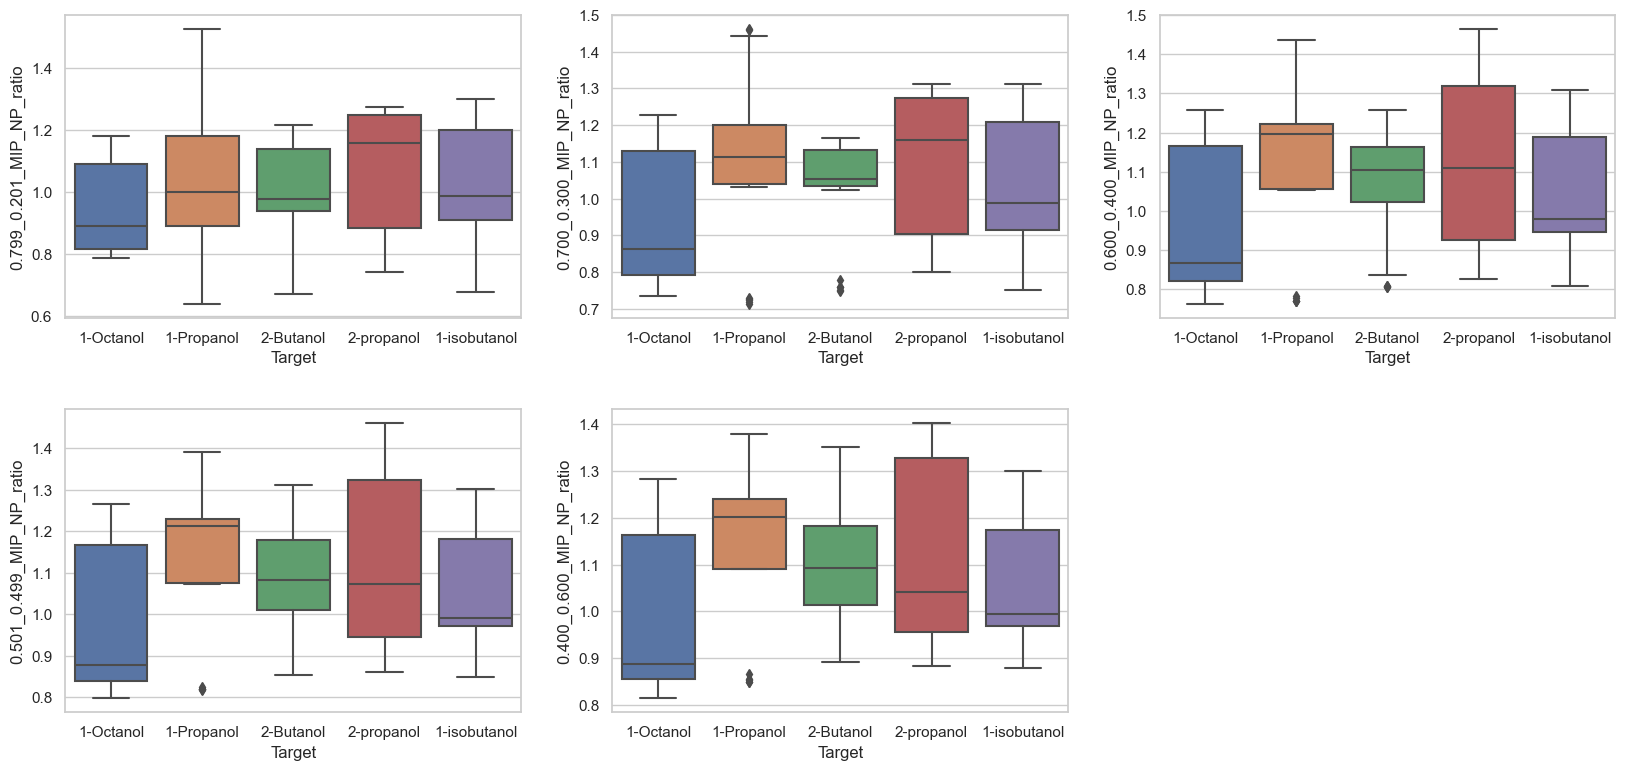

In [15]:
# Create Box Plot based on Target
f=plt.figure(figsize=(20,50))
for i,col in enumerate(feature_columns_ratio):
    f.add_subplot(10,3,i+1)
    sns.boxplot(y=df[col], x=df['Target'])
    plt.subplots_adjust(hspace=0.3)
plt.show()

In terms of ratio
- 1-Octanol and 1-isobutanol generally has lower value across all features
- 2-Propanol and 1-Propanol generally has the second highest value across all features

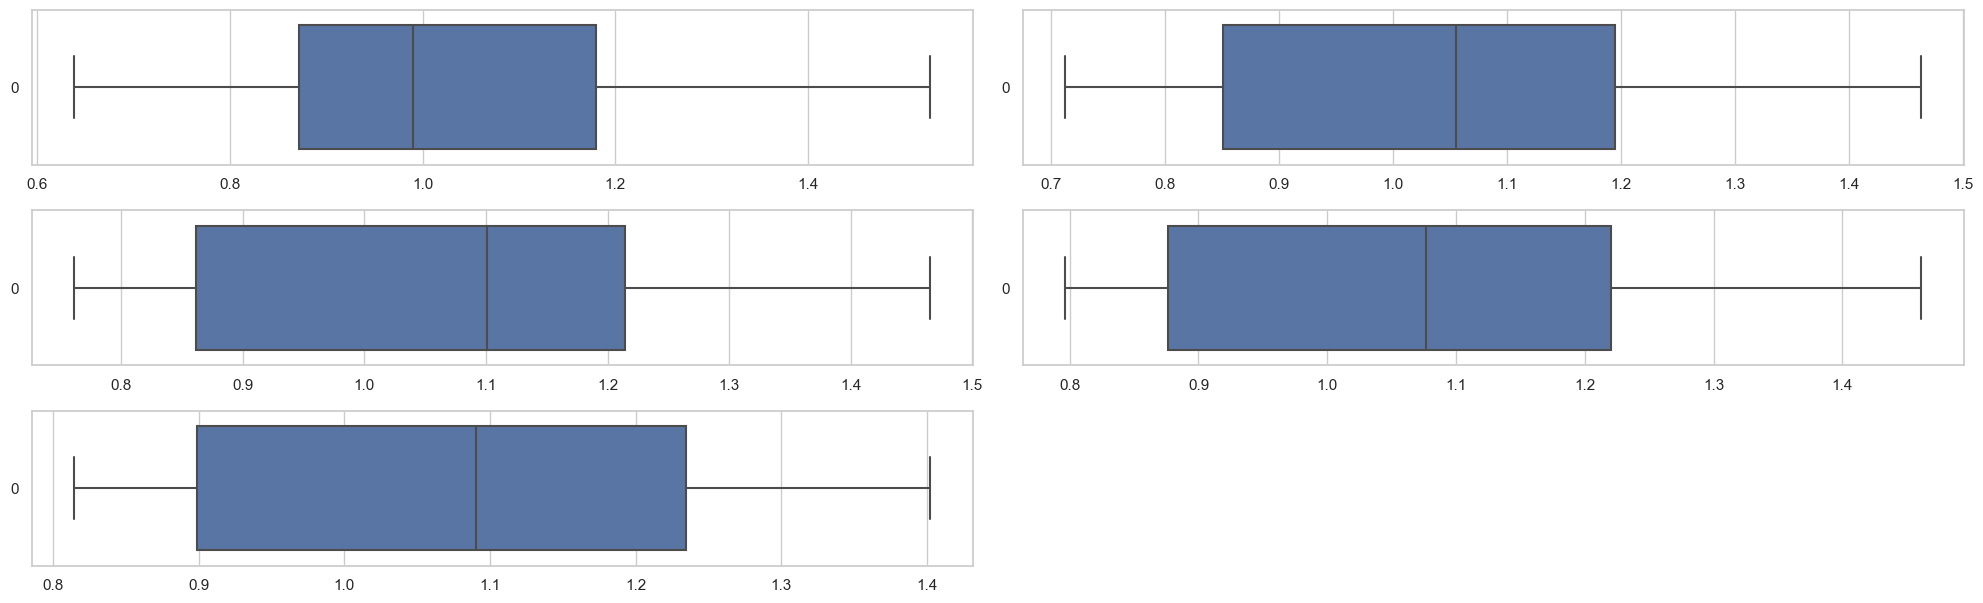

In [16]:
sns.set_theme(style="whitegrid")
f=plt.figure(figsize=(20,40))
for i,col in enumerate(feature_columns_ratio):
    f.add_subplot(20,2,i+1)
    sns.boxplot(df[col], orient = 'h')
    plt.subplots_adjust(hspace=0.7)
    
plt.tight_layout()
plt.show()

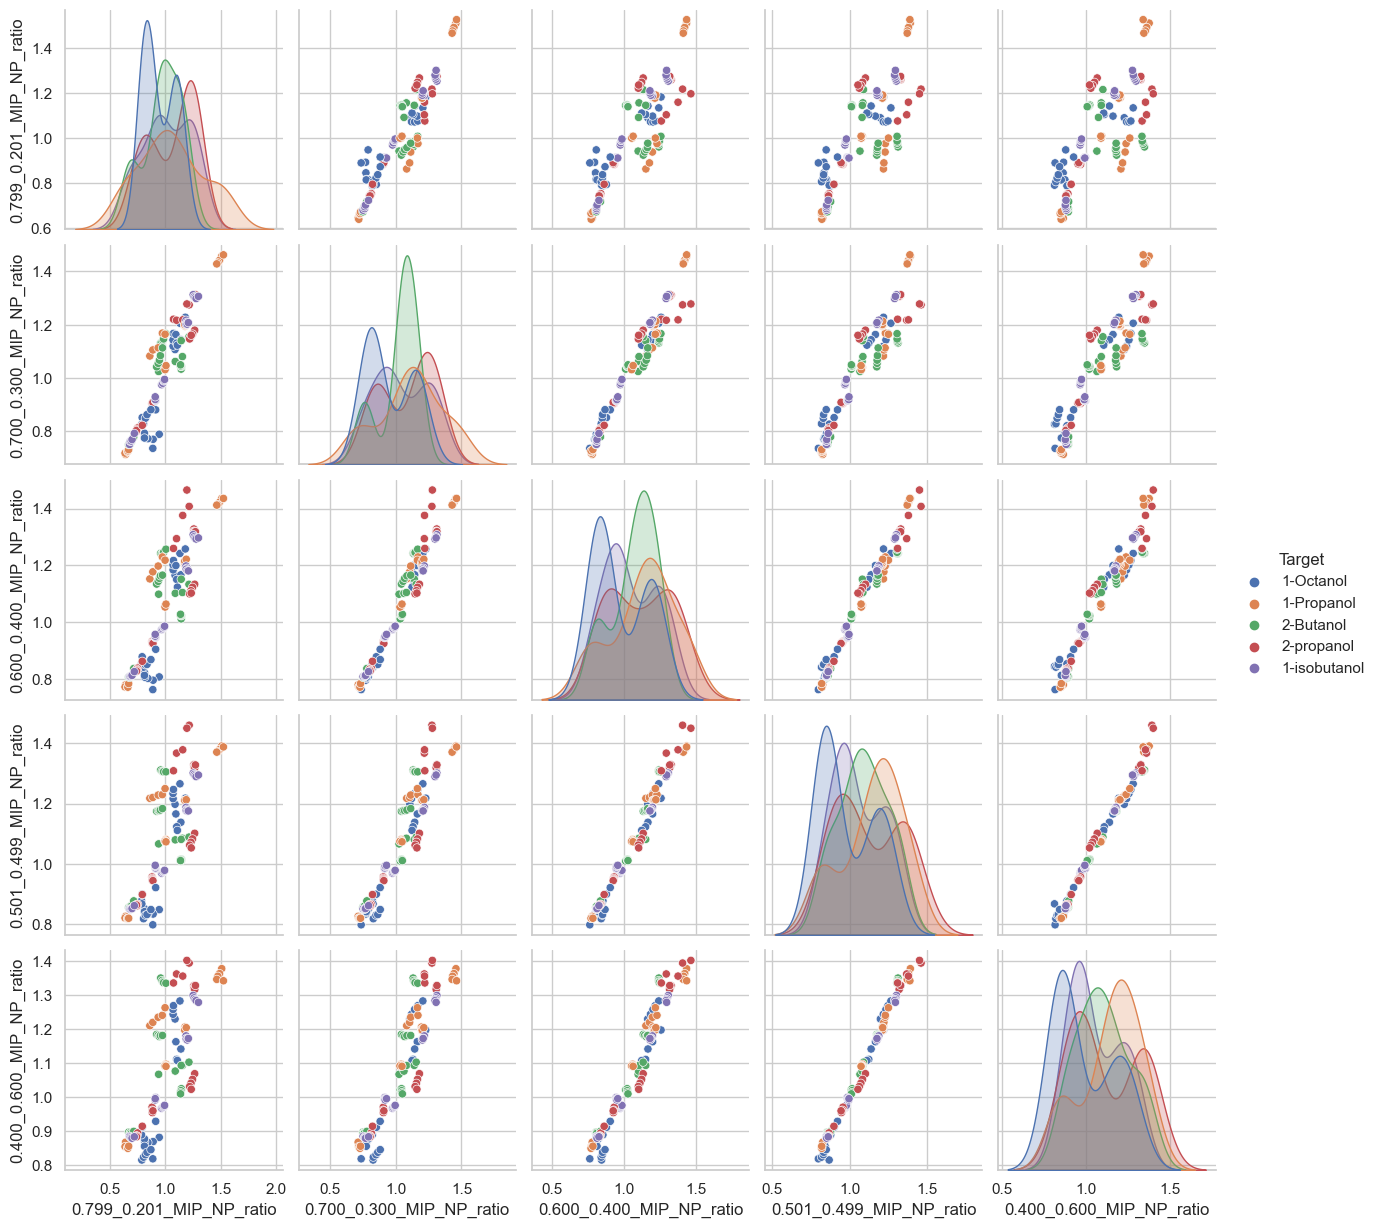

In [17]:
sns.pairplot(df[feature_columns_ratio+['Target']],hue='Target')

## Correlation of engineered features

<Axes: >

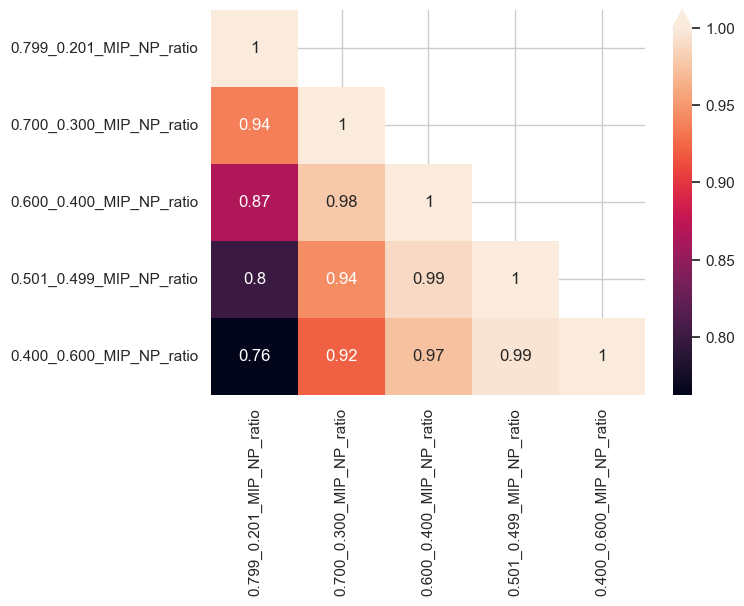

In [18]:
corr_matrix = df[feature_columns_ratio].corr().abs()

# Select upper triangle of correlation matrix
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k = 0).astype('bool'))

# Heat map of numeric variable correlation 
green = sns.light_palette("seagreen", reverse = True, as_cmap = True)
green.set_over('tomato')
plt.figure(figsize = (7,5))
sns.heatmap(lower
            , annot = True
            , cbar_kws = {'extend': 'max'})

In [19]:
vif = pd.DataFrame()
vif["Feature"] = df[feature_columns_ratio].columns
  
# calculating VIF for each feature
vif["VIF"] = [variance_inflation_factor(df[feature_columns_ratio].values, i)
              for i in range(len(df[feature_columns_ratio].columns))]

vif

,Feature,VIF
0,0.799_0.201_MIP_NP_ratio,382.700862
1,0.700_0.300_MIP_NP_ratio,2806.247793
2,0.600_0.400_MIP_NP_ratio,7070.275186
3,0.501_0.499_MIP_NP_ratio,12514.433288
4,0.400_0.600_MIP_NP_ratio,4583.750358


In [20]:
df.shape

(125, 16)

Corelation and multicollinearity issue persists, nevertheless we will try using ***both ratio features and it's raw value***. Multicollinearity in general will be an ***issue for interpretation*** but ***does not have high influence in prediction result***, and ***some method can avoid multicollinearity issue***. We will try to do feature selection steps later.

# 2. Machine Learning

## Train - Test Split

In [21]:
y = df['Target']
X = df.drop(['Target'], axis=1)
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=2, stratify=y)
y_train.value_counts()

Target
1-Propanol      20
1-isobutanol    20
2-propanol      20
1-Octanol       20
2-Butanol       20
Name: count, dtype: int64

In [22]:
feature_columns = feature_columns+feature_columns_ratio

# Baseline models selection

In [23]:
numerical_transformer =  RobustScaler()
#numerical_transformer =  'passthrough'


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, feature_columns),
    ]
)


# logreg
logreg_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=1))]
)

# decision tree
dt_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DecisionTreeClassifier(random_state=1))]
)

# random forest
rf_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=1))]
)

In [24]:
RANDOM_STATE = 1
evaluasi_model = []
   
for model_pipeline,model_name in zip([logreg_clf,dt_clf,rf_clf], ['logistic regression', 'decision tree', 'random forest']) :
    
        # spliting dataset                 
        model = model_name
        
        model_pipeline.set_params(classifier__class_weight="balanced")
        scores = cross_validate(model_pipeline, X_train[feature_columns], y_train, cv=4,n_jobs=2,
                            scoring=['accuracy'],return_train_score=True, error_score='raise')

        # evaluation
        dict1 = {}
        dict1['model'] = model
        dict1['accuracy_train_mean'] = np.mean(scores['train_accuracy'])
        dict1['accuracy_train_std'] = np.std(scores['train_accuracy'])
        dict1['accuracy_test_mean'] = np.mean(scores['test_accuracy'])
        dict1['accuracy_test_std'] = np.std(scores['test_accuracy'])
        evaluasi_model.append(dict1)

evaluasi_model = pd.DataFrame(evaluasi_model)
evaluasi_model

,model,accuracy_train_mean,accuracy_train_std,accuracy_test_mean,accuracy_test_std
0,logistic regression,0.703333,0.047493,0.56,0.084853
1,decision tree,1.000000,0.000000,0.83,0.086603
2,random forest,1.000000,0.000000,0.95,0.033166


Random forest achieved highest score for test accuracy, let's choose random forest and try to optimize it further

## Hyperparameter Tuning

In [25]:
def rf_optimize(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators",100,1000, step = 100),
        'max_depth': trial.suggest_int("max_depth",1,10),
        'n_jobs' : -1,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }

    preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, feature_columns)
    ]
    )
    
        
    rf_clf = Pipeline(
        steps=[("preprocessor", preprocessor),("classifier", RandomForestClassifier(**params, random_state=1))])
    scores = cross_validate(rf_clf, X_train[feature_columns], y_train, cv=StratifiedKFold(random_state=1, shuffle=True),
                            scoring='accuracy',n_jobs=-1)
    cv_score = np.mean(scores['test_score'])
    return cv_score
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=30))
study.optimize(rf_optimize, n_trials=50)

[I 2023-09-26 17:06:52,171] A new study created in memory with name: no-name-eb1a8190-4f6d-4a57-9efb-3805d9924e7b
[I 2023-09-26 17:06:59,483] Trial 0 finished with value: 0.8400000000000001 and parameters: {'n_estimators': 700, 'max_depth': 4, 'criterion': 'gini', 'max_features': None}. Best is trial 0 with value: 0.8400000000000001.
[I 2023-09-26 17:07:05,258] Trial 1 finished with value: 0.9400000000000001 and parameters: {'n_estimators': 300, 'max_depth': 6, 'criterion': 'gini', 'max_features': None}. Best is trial 1 with value: 0.9400000000000001.
[I 2023-09-26 17:07:10,456] Trial 2 finished with value: 0.48 and parameters: {'n_estimators': 1000, 'max_depth': 1, 'criterion': 'entropy', 'max_features': None}. Best is trial 1 with value: 0.9400000000000001.
[I 2023-09-26 17:07:15,196] Trial 3 finished with value: 0.97 and parameters: {'n_estimators': 800, 'max_depth': 7, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 3 with value: 0.97.
[I 2023-09-26 17:07:15,767] Tri

In [26]:
best_params = study.best_params
best_params

{'n_estimators': 300,
 'max_depth': 8,
 'criterion': 'gini',
 'max_features': 'log2'}

In [27]:
study.best_value

0.9800000000000001

Accuracy has improved from 95% to 98%

In [28]:
preprocessor = ColumnTransformer(
transformers=[
    ("num", numerical_transformer, feature_columns),
]
)

rf_clf = Pipeline(
    steps=[("preprocessor", preprocessor) ,("classifier", RandomForestClassifier(class_weight= 'balanced',
                                                                             **best_params,random_state=1))])

scores = cross_validate(rf_clf, X_train[feature_columns], y_train, cv=StratifiedKFold(random_state=1,shuffle=True),
                            scoring=['accuracy'],return_train_score=True)
for f in [f for f in scores.keys() if f not in ['fit_time', 'score_time']]:
    print(f"{f} : {np.mean(scores[f])}")

test_accuracy : 0.9800000000000001
train_accuracy : 1.0


In [29]:
rf_clf.fit(X_train[feature_columns], y_train)
y_pred_train = rf_clf.predict(X_train)
y_pred_test = rf_clf.predict(X_test)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00        20
  1-Propanol       1.00      1.00      1.00        20
1-isobutanol       1.00      1.00      1.00        20
   2-Butanol       1.00      1.00      1.00        20
  2-propanol       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [30]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00         5
  1-Propanol       1.00      1.00      1.00         5
1-isobutanol       0.83      1.00      0.91         5
   2-Butanol       1.00      0.80      0.89         5
  2-propanol       1.00      1.00      1.00         5

    accuracy                           0.96        25
   macro avg       0.97      0.96      0.96        25
weighted avg       0.97      0.96      0.96        25



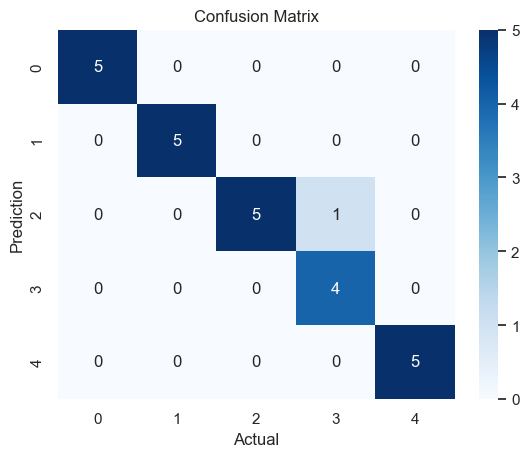

In [31]:
# Train confusion chart
def display_conf(ypred_train, y_train):
    sns.heatmap(confusion_matrix(y_train, ypred_train),annot=True,fmt='', cmap="Blues")
    plt.title('Confusion Matrix')
    plt.ylabel('Prediction')
    plt.xlabel('Actual')
    plt.show()

display_conf(y_test, y_pred_test)

Only 1 (4%) sample in data test is being missclassified

# Feature Selection

As we have a lot of multicorellated features which are potentially redundant. We can try to do feature selection to pick important features using sklearn SelectFromModel method. It calculate feautre importance threshold of an estimator, in this case our random forest model

In [32]:
from sklearn.feature_selection import SelectFromModel
X_train_scaled = rf_clf['preprocessor'].fit_transform(X_train[feature_columns])
selector = SelectFromModel(estimator=rf_clf['classifier']).fit(X_train_scaled, y_train)
selector.threshold_

0.06666666666666667

Minimum feature importances is 6.67%

In [33]:
column_idx = selector.get_support(indices=True)
selected_cols = [feature_columns[c] for c in column_idx]
selected_cols

['0.799_0.201_MIP',
 '0.799_0.201_NP',
 '0.700_0.300_MIP',
 '0.700_0.300_NP',
 '0.501_0.499_NP']

In [34]:
preprocessor = ColumnTransformer(
transformers=[
    ("num", numerical_transformer, selected_cols),
]
)

rf_clf_fs = Pipeline(
    steps=[("preprocessor", preprocessor) ,("classifier", RandomForestClassifier(class_weight= 'balanced',
                                                                             **best_params,random_state=1))])

scores = cross_validate(rf_clf_fs, X_train[selected_cols], y_train, cv=StratifiedKFold(random_state=1,shuffle=True),
                            scoring=['accuracy'],return_train_score=True)
for f in [f for f in scores.keys() if f not in ['fit_time', 'score_time']]:
    print(f"{f} : {np.mean(scores[f])}")

test_accuracy : 0.9399999999999998
train_accuracy : 1.0


We achieved comparable test accuracy with significantly less number of predictors to use

In [35]:
rf_clf_fs.fit(X_train[selected_cols], y_train)
y_pred_train = rf_clf_fs.predict(X_train)
y_pred_test = rf_clf_fs.predict(X_test)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00        20
  1-Propanol       1.00      1.00      1.00        20
1-isobutanol       1.00      1.00      1.00        20
   2-Butanol       1.00      1.00      1.00        20
  2-propanol       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [36]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00         5
  1-Propanol       0.83      1.00      0.91         5
1-isobutanol       0.71      1.00      0.83         5
   2-Butanol       1.00      0.60      0.75         5
  2-propanol       1.00      0.80      0.89         5

    accuracy                           0.88        25
   macro avg       0.91      0.88      0.88        25
weighted avg       0.91      0.88      0.88        25



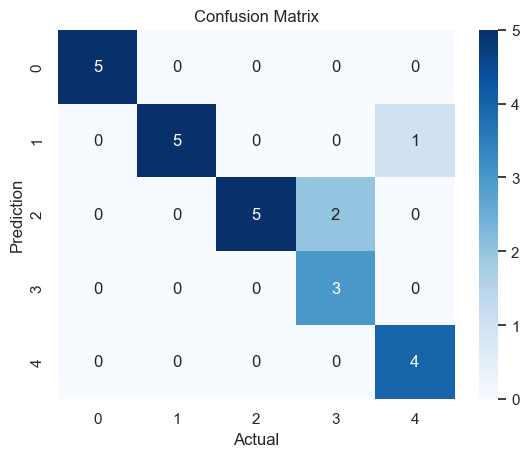

In [37]:
display_conf(y_test, y_pred_test)

Unfortunately with feature selection we have an issue of overfitting although only small sample is available, let's see if redoing parameter tuning will help.

In [38]:
def rf_optimize(trial):
    params = {
        'n_estimators': trial.suggest_int("n_estimators",100,1000, step = 100),
        'max_depth': trial.suggest_int("max_depth",1,10),
        'n_jobs' : -1,
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }

    preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, selected_cols)
    ]
    )
    
        
    rf_clf_fs = Pipeline(
        steps=[("preprocessor", preprocessor),("classifier", RandomForestClassifier(**params, random_state=1))])
    scores = cross_validate(rf_clf_fs, X_train[selected_cols], y_train, cv=StratifiedKFold(random_state=1, shuffle=True),
                            scoring='accuracy',n_jobs=-1)
    cv_score = np.mean(scores['test_score'])
    return cv_score
study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=30))
study.optimize(rf_optimize, n_trials=50)

[I 2023-09-26 17:09:07,944] A new study created in memory with name: no-name-b3352d27-a18a-4c98-853b-845115339a21
[I 2023-09-26 17:09:10,679] Trial 0 finished with value: 0.82 and parameters: {'n_estimators': 700, 'max_depth': 4, 'criterion': 'gini', 'max_features': None}. Best is trial 0 with value: 0.82.
[I 2023-09-26 17:09:11,903] Trial 1 finished with value: 0.8600000000000001 and parameters: {'n_estimators': 300, 'max_depth': 6, 'criterion': 'gini', 'max_features': None}. Best is trial 1 with value: 0.8600000000000001.
[I 2023-09-26 17:09:15,927] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 1000, 'max_depth': 1, 'criterion': 'entropy', 'max_features': None}. Best is trial 1 with value: 0.8600000000000001.
[I 2023-09-26 17:09:19,138] Trial 3 finished with value: 0.9399999999999998 and parameters: {'n_estimators': 800, 'max_depth': 7, 'criterion': 'entropy', 'max_features': 'log2'}. Best is trial 3 with value: 0.9399999999999998.
[I 2023-09-26 17:09:19,741] Tria

In [39]:
best_params = study.best_params
best_params

{'n_estimators': 400,
 'max_depth': 9,
 'criterion': 'gini',
 'max_features': 'sqrt'}

In [40]:
preprocessor = ColumnTransformer(
transformers=[
    ("num", numerical_transformer, selected_cols),
]
)

rf_clf_fs = Pipeline(
    steps=[("preprocessor", preprocessor) ,("classifier", RandomForestClassifier(class_weight= 'balanced',
                                                                             **best_params,random_state=1))])

scores = cross_validate(rf_clf_fs, X_train[selected_cols], y_train, cv=StratifiedKFold(random_state=1,shuffle=True),
                            scoring=['accuracy'],return_train_score=True)
for f in [f for f in scores.keys() if f not in ['fit_time', 'score_time']]:
    print(f"{f} : {np.mean(scores[f])}")

test_accuracy : 0.96
train_accuracy : 1.0


In [41]:
rf_clf_fs.fit(X_train[selected_cols], y_train)
y_pred_train = rf_clf_fs.predict(X_train)
y_pred_test = rf_clf_fs.predict(X_test)
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00        20
  1-Propanol       1.00      1.00      1.00        20
1-isobutanol       1.00      1.00      1.00        20
   2-Butanol       1.00      1.00      1.00        20
  2-propanol       1.00      1.00      1.00        20

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [42]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00         5
  1-Propanol       0.83      1.00      0.91         5
1-isobutanol       0.71      1.00      0.83         5
   2-Butanol       1.00      0.60      0.75         5
  2-propanol       1.00      0.80      0.89         5

    accuracy                           0.88        25
   macro avg       0.91      0.88      0.88        25
weighted avg       0.91      0.88      0.88        25



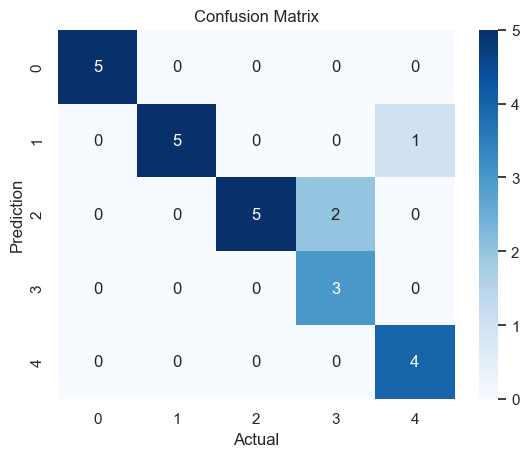

In [43]:
display_conf(y_test, y_pred_test)

Overfitting issue persists, we will use previous model with all columns instead.
* Side note: it is actually hard to justify overfitting with such ***small sample*** as one false prediction would be a ***huge loss of accuracy in percentage***. With this dataset, if for example we achieved accuracy of 90% using feature selection then I would still choose model with feature selection. 

## Feature Importances

<Axes: >

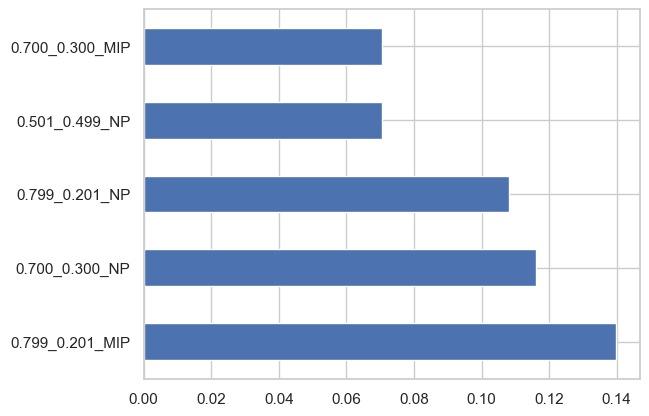

In [44]:
importances = pd.Series(
    rf_clf.named_steps['classifier'].feature_importances_, index= X[feature_columns].columns)
importances.nlargest(5).plot(kind='barh')

From feature importance obtained through random forest fitting result, we can see that the model prioritize MIP and NP value when exposed to 0.799 : 0.201 Air : Gas ratio when doing prediction

# 3. Artificial Neural Network

## Preprocessing Steps
- Label Encode target variable as Keras can only deal with numeric.

## ANN layers
- Layers used below is achieved through manual tuning. Started with only one dense layer then adding more layers and/or layer units to improve accuracy.
- Each dense layer use ReLU activation function.
- Normalization layer in the first layer to scale numeric values.
- Dropout layer is added in each dense layer for regularization to avoid overfitting. We use 20 percent drop rate for each layer.
- Output layer with softmax activation function for multiclass classification, with 5 units which corresponds to number of classes. 
- Learning rate will gradualy be decreased during training to ensure achieving convergence optimally.

## Evaluation
- SparseCategoricalAccuracy used as accuracy for multiclass classification
- SparseCategoricalCrossentropy used as loss for multiclass classification

In [54]:
le = LabelEncoder()
le.fit(y_train)
label_train = le.transform(y_train)
label_test = le.transform(y_test)
tf.keras.backend.clear_session()
model_nn = tf.keras.models.Sequential([
                                    tf.keras.layers.Normalization(),
                                    tf.keras.layers.Dense(32,activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(64,activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(128,activation=tf.nn.relu),
                                    tf.keras.layers.Dropout(0.2),
                                    tf.keras.layers.Dense(5, activation=tf.nn.softmax)])

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.002,
  decay_steps=1000,
  decay_rate=1,
  staircase=False)
model_nn.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())
epochs = 1000
history = model_nn.fit(X_train, label_train
                       ,epochs=epochs
                       , validation_data=[X_test, label_test]

                       )

Epoch 1/1000
4/4 [==============================] - 2s 84ms/step - loss: 34.5623 - sparse_categorical_accuracy: 0.1600 - val_loss: 13.2121 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/1000
4/4 [==============================] - 0s 15ms/step - loss: 24.7659 - sparse_categorical_accuracy: 0.2500 - val_loss: 8.9024 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/1000
4/4 [==============================] - 0s 16ms/step - loss: 17.0280 - sparse_categorical_accuracy: 0.2400 - val_loss: 10.1686 - val_sparse_categorical_accuracy: 0.2000
Epoch 4/1000
4/4 [==============================] - 0s 16ms/step - loss: 15.9734 - sparse_categorical_accuracy: 0.2600 - val_loss: 2.7644 - val_sparse_categorical_accuracy: 0.4400
Epoch 5/1000
4/4 [==============================] - 0s 16ms/step - loss: 14.2737 - sparse_categorical_accuracy: 0.1700 - val_loss: 5.7800 - val_sparse_categorical_accuracy: 0.2000
Epoch 6/1000
4/4 [==============================] - 0s 16ms/step - loss: 12.9052 - sparse_categori

In [55]:
model_nn.evaluate(X_test, label_test)

1/1 [==============================] - 0s 35ms/step - loss: 0.2346 - sparse_categorical_accuracy: 0.9600


[0.23458373546600342, 0.9599999785423279]

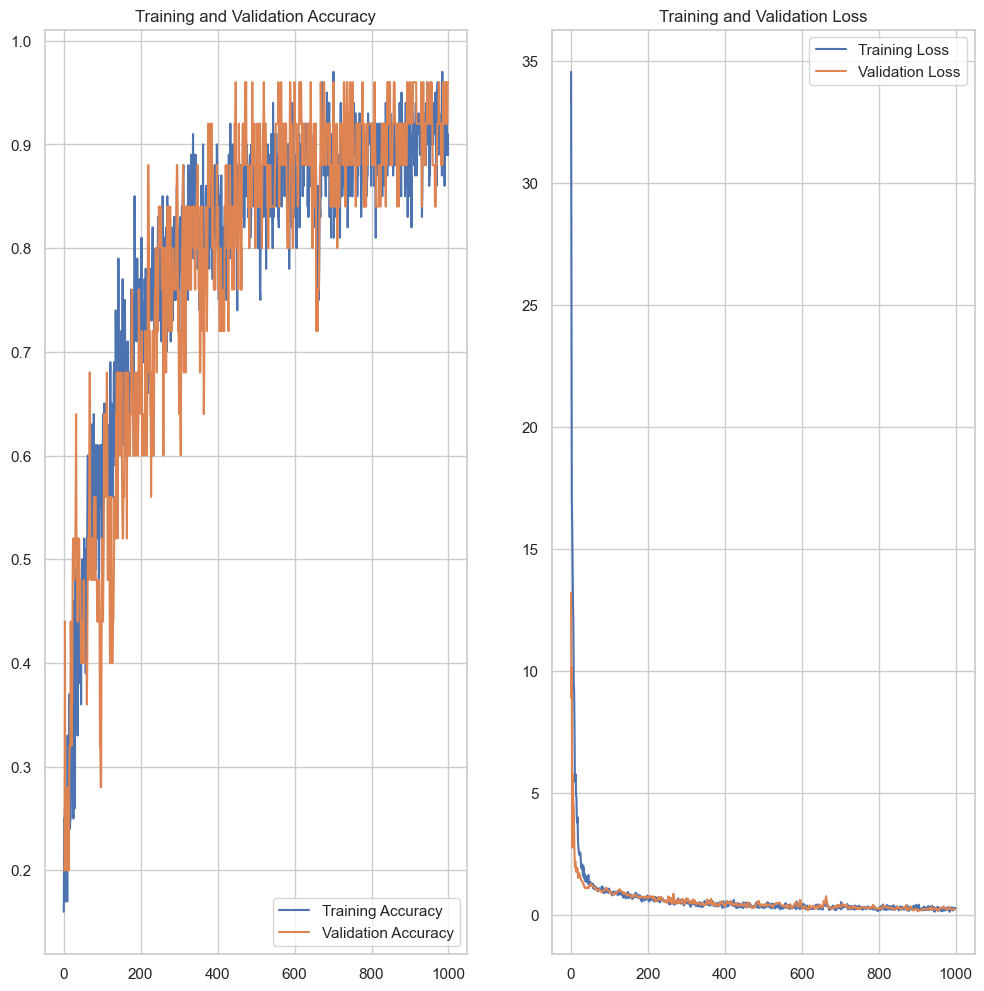

In [56]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Both training and validation accuracy and loss aligned quite well indicates low overfitting issue.

In [57]:
y_prob = model_nn.predict(X_test)
y_pred = y_prob.argmax(axis=1)
y_pred = le.inverse_transform(y_pred)
print(classification_report(y_test,y_pred))

1/1 [==============================] - 0s 86ms/step
              precision    recall  f1-score   support

   1-Octanol       1.00      1.00      1.00         5
  1-Propanol       1.00      1.00      1.00         5
1-isobutanol       0.83      1.00      0.91         5
   2-Butanol       1.00      0.80      0.89         5
  2-propanol       1.00      1.00      1.00         5

    accuracy                           0.96        25
   macro avg       0.97      0.96      0.96        25
weighted avg       0.97      0.96      0.96        25



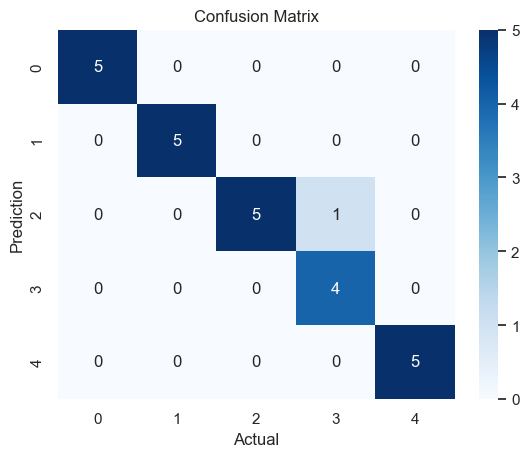

In [58]:
display_conf(y_test, y_pred)

We achieved comparable result between ANN and ML algorithm. Let's save both model to be served in our API.

In [61]:
import joblib
joblib.dump(rf_clf,os.path.join(os.getcwd(),'random_forest.pkl'))
model_nn.save('ANN.keras')